In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 10.1

In [2]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1

#### Code 10.2

In [3]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:03<00:00, 677.00it/s] 


In [4]:
df_10_1 = pm.df_summary(trace_10_1, alpha=0.11)
df_10_1.round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
a,0.32,0.09,0.00,0.18,0.45
bp,-0.13,10.02,0.15,-15.30,16.80


#### Code 10.3

In [5]:
logistic(df_10_1.iloc[:,-2:]).round(2)

,hpd_5.5,hpd_94.5
a,0.54,0.61
bp,0.00,1.00


#### Code 10.4

In [6]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(2000)

with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:06<00:00, 367.30it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:09<00:00, 263.73it/s]


#### Code 10.5

In [7]:
comp_df = pm.compare(traces=[trace_10_1, trace_10_2, trace_10_3],
                     models=[model_10_1, model_10_2, model_10_3],
                     method='pseudo-BMA')
comp_df.round(2)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,680.64,2.07,0,0.69,9.36,0,0
2,682.39,3.02,1.75,0.29,9.48,0.85,0
0,687.84,0.95,7.2,0.02,7.1,6.2,0


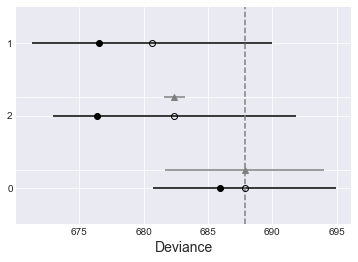

In [8]:
pm.compareplot(comp_df);

#### Code 10.6

In [9]:
pm.df_summary(trace_10_3).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.05,0.12,0.0,-0.18,0.30
bp,0.62,0.23,0.0,0.16,1.06
bpC,-0.11,0.26,0.0,-0.60,0.41


#### Code 10.7

In [10]:
np.exp(0.61)

1.8404313987816374

#### Code 10.8

In [11]:
logistic(4)

0.98201379003790845

#### Code 10.9

In [12]:
logistic(4 + 0.61)

0.99014624447676869

#### Code 10.10 and 10.11

In [13]:
d_pred = pd.DataFrame({'prosoc_left' : [0, 1, 0, 1], 'condition' : [0, 0, 1, 1]})
traces = [trace_10_1, trace_10_2, trace_10_3]
models = [model_10_1, model_10_2, model_10_3]


chimp_ensemble = pm.sample_ppc_w(traces=traces, models=models, samples=1000, 
                                 weights=comp_df.weight.sort_index(ascending=True))

100%|██████████| 1000/1000 [00:00<00:00, 1098.66it/s]


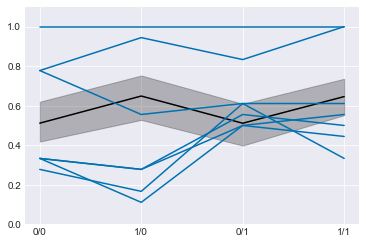

In [14]:
rt = chimp_ensemble['pulled_left']
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left==pl) & (d.chose_prosoc==cp)]))
    pred_mean[i] = tmp
    
ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
for i in range(7):
    plt.plot(chimps[i], 'C0')

plt.ylim(0, 1.1);

#### Code 10.12 & 10.13
This is the same as 10.6, but in the book using MCMC rather than quadratic approximation.

#### Code 10.14

In [15]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 2493/2500 [00:18<00:00, 147.29it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:18<00:00, 132.72it/s]
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


#### Code 10.15

In [16]:
# remember we use a zero-index
d['actor'].unique()

array([0, 1, 2, 3, 4, 5, 6])

#### Code 10.16

In [17]:
pm.df_summary(trace_10_4, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha__0,-0.74,0.27,0.00,-1.17,-0.34
alpha__1,10.99,5.41,0.12,3.42,18.22
alpha__2,-1.06,0.27,0.00,-1.48,-0.61
alpha__3,-1.06,0.28,0.00,-1.49,-0.60
alpha__4,-0.74,0.27,0.01,-1.15,-0.31
alpha__5,0.22,0.27,0.00,-0.18,0.66
alpha__6,1.82,0.40,0.01,1.23,2.47
bp,0.84,0.26,0.00,0.41,1.22
bpC,-0.13,0.30,0.01,-0.63,0.32


#### Code 10.17

In [18]:
post = pm.trace_to_dataframe(trace_10_4)
post.head()

,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6,bp,bpC
0,-0.369312,6.849977,-0.546569,-0.695015,-0.427984,0.199945,1.714003,0.255933,0.125693
1,-0.405906,11.154481,-1.136661,-1.118322,-0.240653,0.014442,2.471327,0.456748,0.347902
2,-0.429169,10.953168,-0.811195,-0.798750,-0.507882,0.450651,1.583074,0.758291,-0.163970
3,-0.543426,9.227145,-0.913931,-0.909290,-0.641100,0.457433,1.575499,0.795047,-0.483523
4,-0.375340,14.038686,-0.077812,-0.670046,-0.435943,0.332426,1.480141,0.758258,-0.543883


#### Code 10.18

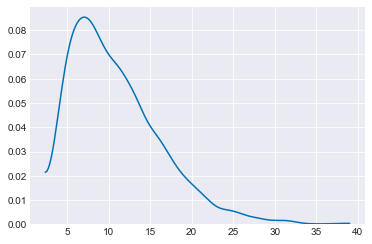

In [19]:
pm.kdeplot(post['alpha__1']);

#### Code 10.19

In [20]:
rt = pm.sample_ppc(trace_10_4, 1000, model_10_4)['pulled_left']

100%|██████████| 1000/1000 [00:00<00:00, 1176.21it/s]


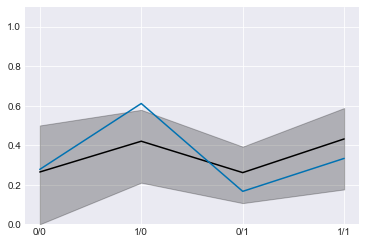

In [21]:
chimp = 2
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left == pl) & (d.chose_prosoc == cp) & (d.actor == chimp)]))
    pred_mean[i] = tmp

ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean, alpha=0.11)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d[d.actor == chimp].groupby(['condition', 'prosoc_left', ]).agg('mean')['pulled_left'].values
plt.plot(chimps, 'C0')

plt.ylim(0, 1.1);

#### Code 10.20

In [22]:
d_aggregated = d.groupby(['actor', 'condition', 'prosoc_left',  ])['pulled_left'].sum().reset_index()
d_aggregated.head(7)

,actor,condition,prosoc_left,pulled_left
0,0,0,0,6
1,0,0,1,9
2,0,1,0,5
3,0,1,1,10
4,1,0,0,18
5,1,0,1,18
6,1,1,0,18


#### Code 10.21

In [23]:
with pm.Model() as model_10_5:
    a = pm.Normal('alpha', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d_aggregated.condition) * d_aggregated.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_10_5 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:07<00:00, 352.83it/s]


In [24]:
pm.df_summary(trace_10_5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.047711,0.129219,0.002632,-0.199846,0.298299
bp,0.619034,0.234444,0.005256,0.133041,1.055039
bpC,-0.111058,0.263873,0.005778,-0.632894,0.396342


In [25]:
# hacky check of similarity to 10_3, within a hundreth
np.isclose(pm.df_summary(trace_10_5), pm.df_summary(trace_10_3), atol=0.01)

array([[ True,  True,  True, False,  True],
       [ True,  True,  True, False,  True],
       [ True,  True,  True, False, False]], dtype=bool)

#### Code 10.22

In [26]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


#### Code 10.23

In [27]:
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)

with pm.Model() as model_10_6:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a + bm * d_ad.male)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_6 = pm.sample(2000, tune=1000)
    
with pm.Model() as model_10_7:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_7 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3000/3000 [00:07<00:00, 409.01it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3000/3000 [00:02<00:00, 1065.86it/s]


#### Code 10.24

In [28]:
# Something goofy here... 
# not even close to WAIC values, larger standard error

comp_df = pm.compare([trace_10_6, trace_10_7], [model_10_6, model_10_7], method='pseudo-BMA')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,988.84,112.82,0,1,313.56,0,1
1,1051.26,85.37,62.42,0,315.56,161.82,1


#### Code 10.25

In [29]:
pm.df_summary(trace_10_6).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,-0.83,0.05,0.0,-0.93,-0.73
bm,0.61,0.06,0.0,0.49,0.74


#### Code 10.26

In [30]:
post = pm.trace_to_dataframe(trace_10_6)
p_admit_male = logistic(post['a'] + post['bm'])
p_admit_female = logistic(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

2.5%     0.113051
50%      0.141382
97.5%    0.169554
dtype: float64

#### Code 10.27

(0, 1)

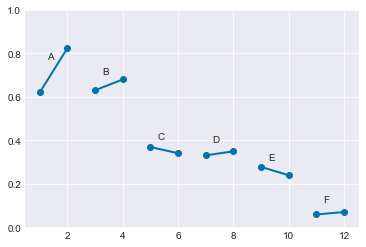

In [31]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])
plt.ylim(0, 1)

#### Code 10.28

In [32]:
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [36]:
with pm.Model() as model_10_8:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(2000)

with pm.Model() as model_10_9:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a[d_ad['dept_id'].values] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_9 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 526.49it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:06<00:00, 387.67it/s]


#### Code 10.29

In [37]:
# WAIC values still off
# Plus warning flag

comp_df = pm.compare(traces=[trace_10_6, trace_10_7, trace_10_8, trace_10_9],
                     models=[model_10_6, model_10_7, model_10_8, model_10_9], method='pseudo-BMA')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
2,105.16,6.57,0,0.9,17.12,0,1
3,109.45,9.94,4.29,0.1,15.89,3.37,1
0,988.84,112.82,883.69,0,313.56,310.67,1
1,1051.26,85.37,946.1,0,315.56,313.19,1


#### Code 10.30

In [38]:
pm.df_summary(trace_10_9).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a__0,0.68,0.10,0.0,0.49,0.89
a__1,0.64,0.12,0.0,0.40,0.86
a__2,-0.58,0.07,0.0,-0.72,-0.43
a__3,-0.61,0.09,0.0,-0.77,-0.44
a__4,-1.06,0.10,0.0,-1.25,-0.86
a__5,-2.63,0.16,0.0,-2.95,-2.33
bm,-0.10,0.08,0.0,-0.25,0.06


#### Code 10.31
Replicated model above but with MCMC in book.

In [39]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.1
Pandas 0.20.3
SciPy 0.19.1
Matplotlib 2.0.2

